In [4]:
!pip install torchinfo

In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import yfinance as yf
import sklearn
import networkx as nx
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

#Возможные проблемы

Накопление ошибок при прогнозировании: Функция forecast предсказывает каждый следующий день, используя предыдущие предсказания как вход. Ошибки на ранних шагах накапливаются, и со временем модель (например, GRU) начинает выдавать почти постоянные значения, часто близкие к среднему.

Выход за границы обучающих данных: При прогнозе модель может выдавать значения, которые после обратного масштабирования окажутся вне диапазона [0, 1]. Во время обучения модель видела только нормализованные значения, поэтому она плохо справляется с экстремальными колебаниями, что особенно критично для волатильных активов, таких как криптовалюты.

Недостаток признаков: В текущей реализации не учитываются дополнительные факторы, влияющие на цену, например, объём торгов, волатильность и другие рыночные индикаторы.

Слабая архитектура модели: Простая модель с 2 слоями по 32 нейрона может быть недообучена. Кроме того, seq_length=60 дней может быть слишком большим для такой модели, учитывая высокую изменчивость криптовалютного рынка.

Отсутствие регуляризации: Модель может переобучаться или плохо обобщать данные без методов регуляризации.

Волатильность рынка: Криптовалюты характеризуются высокой непредсказуемостью, что усложняет точное прогнозирование.

Недостаточное обучение: Модель могла не достигнуть оптимальных весов из-за ограниченного числа эпох или неправильной настройки обучения.

[*********************100%***********************]  1 of 1 completed


Epoch 000 | Loss: 0.018340
Epoch 005 | Loss: 0.000392
Epoch 010 | Loss: 0.000355
Epoch 015 | Loss: 0.000333


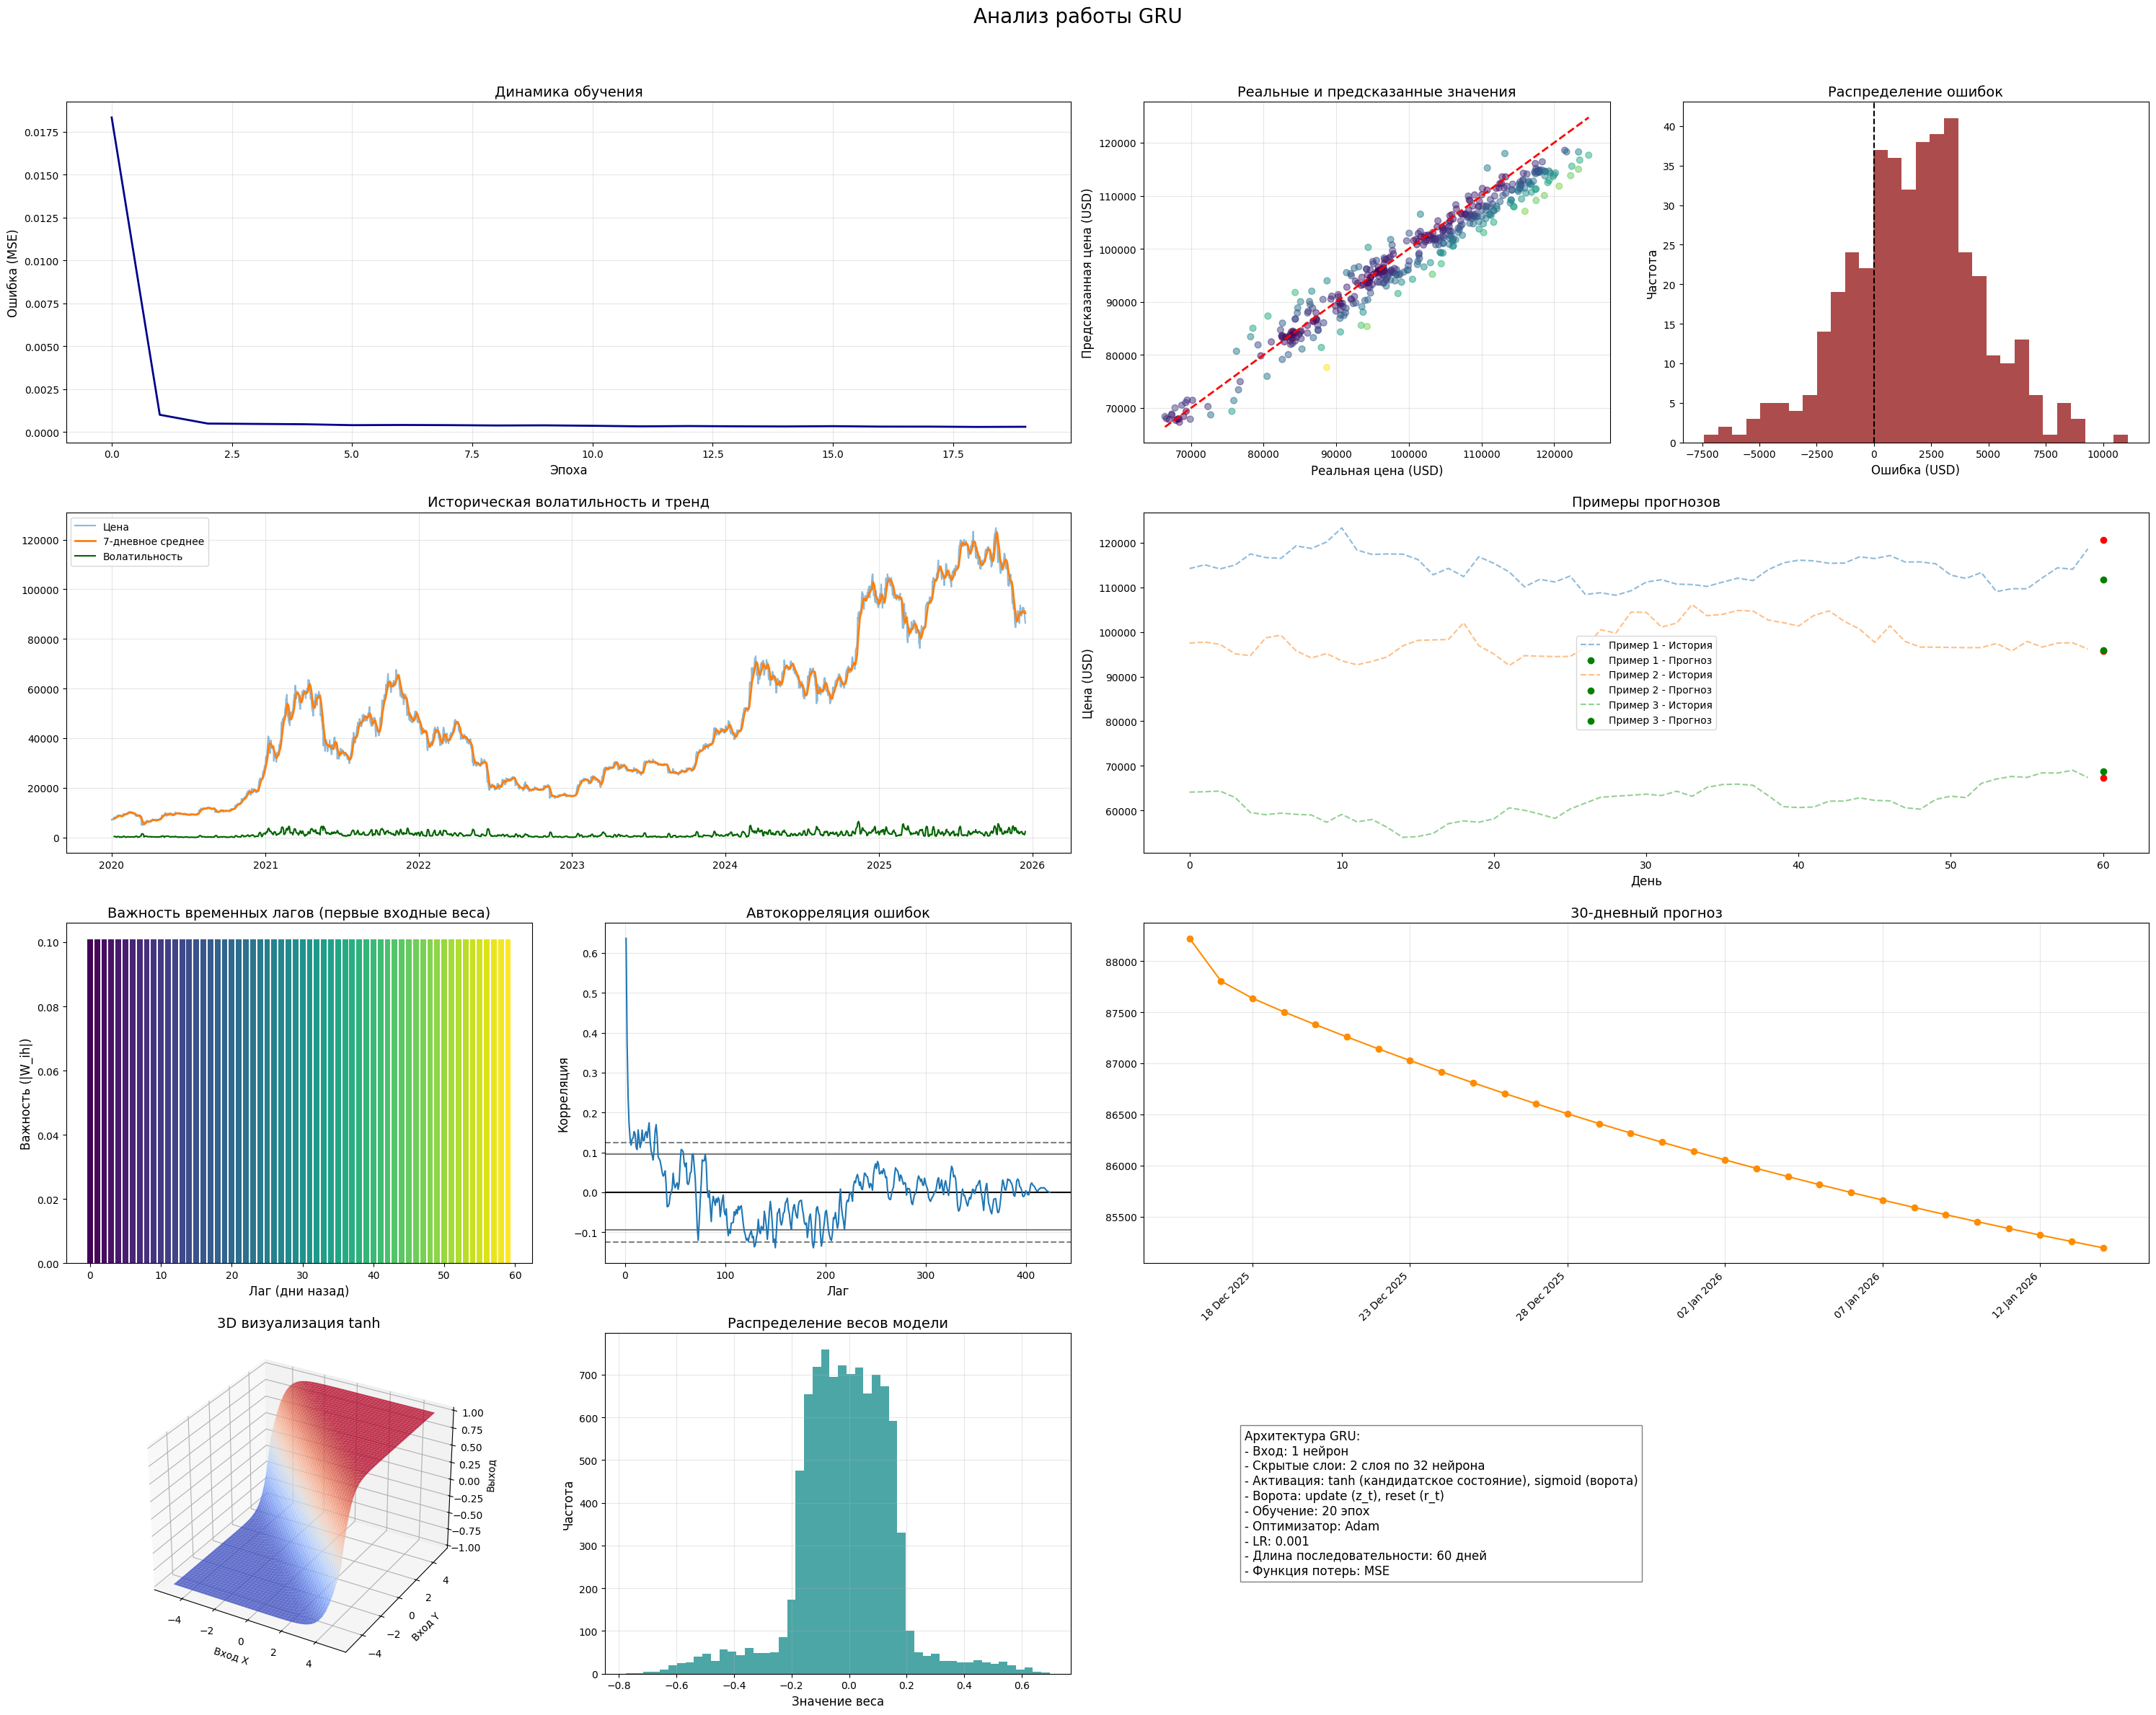

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler

ticker = "BTC-USD"
seq_length = 60
batch_size = 32
num_epochs = 20
lr = 0.001
forecast_days = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = yf.download(
    ticker,
    start="2020-01-01",
    end=pd.Timestamp.now().strftime("%Y-%m-%d")
)
data = data[["Close"]]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

X, y = create_sequences(scaled_data, seq_length)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class BitcoinGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=x.device
        )
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

model = BitcoinGRU().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

dataset = torch.utils.data.TensorDataset(X_train, y_train)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_X.size(0)

    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.6f}")

def forecast(model, sequence, days, device):
    model.eval()
    seq = sequence.clone().to(device).squeeze(0)
    preds = []

    with torch.no_grad():
        for _ in range(days):
            p = model(seq.unsqueeze(0))
            p = torch.clamp(p, 0.0, 1.0)
            preds.append(p.item())
            seq = torch.cat((seq[1:], p))

    return np.array(preds)

last_sequence = torch.FloatTensor(
    scaled_data[-seq_length:]
).unsqueeze(0)

scaled_forecast = forecast(
    model,
    last_sequence,
    forecast_days,
    device
)

forecast_prices = scaler.inverse_transform(
    scaled_forecast.reshape(-1, 1)
)

model.eval()
test_predictions = []

with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0).to(device))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы GRU", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))

    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для GRU)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя GRU
gru_weights = model.gru.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(gru_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура GRU:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (кандидатское состояние), sigmoid (ворота)
- Ворота: update (z_t), reset (r_t)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

# Вывод
Я исправил ошибки в логике и коде, после чего модель начала показывать лучшие результаты